In [1]:
import json
import numpy as np
import os
import pandas as pd
import pickle
import random
import scipy
import sys
import matplotlib.pyplot as plt
import time
import math
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist
from scipy import stats
from dtwalign import dtw_low, dtw
from sklearn.cluster import AffinityPropagation
from numpy.polynomial.polynomial import polyfit
from matplotlib import style
style.use('ggplot')
from random import randint    

In [2]:
def hampel(vals_orig, W=7, t0=3):
    '''
    vals: pandas series of values from which to remove outliers
    W: size of window (including the sample; 7 is equal to 3 on either side of value)
    '''
    #Make copy so original not edited
    vals=vals_orig.copy()    
    #Hampel Filter
    L= 1.4826
    rolling_median=vals.rolling(W).median()
    difference=np.abs(rolling_median-vals)
    median_abs_deviation=difference.rolling(W).median()
    threshold= t0 * L * median_abs_deviation
    outlier_idx=difference>threshold
    vals[outlier_idx]=rolling_median #np.nan
    return(vals)

In [3]:
def distance_cal(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371.0 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [6]:
result = pd.read_csv('substations_address.csv', index_col=0, header=0)
seeds=[]


for items in result['6']:
    items = list(map(float, items[1:-1].split(', ')))
    if items[0] != 39.19002151489258 and items[0] != np.NaN:
        seeds.append(items)
seeds = np.asarray(seeds)

substations=[]
for k in range(len(result['0'])):
    substations.append(result['0'][k])

In [10]:
dataset = pd.DataFrame()
df = pd.DataFrame()
df_data = pd.DataFrame()
data = []


s_date = '-01-01' 
e_date = '-12-31'
years = ['2015','2016','2017','2018']

column=['sec_delta_t','prim_delta_t','meter_effect',
        'meter_prim_return_temp','meter_prim_supply_temp',
        'meter_volume_flow','outdoor_temp','sec_return_temp',
        'sec_supply_temp', 'station_energy_flow', 'gradenkeit',
        'station_efficiency_temp']

for year in years:
    print(year)
        
        try:
            dataset = inputData[k].loc[year + s_date:year + e_date].resample('H').mean()
            dataset = dataset.drop(['meter_heatenergy','meter_volume'], axis=1)
            dataset = dataset.drop_duplicates()
            dataset.dropna(inplace=True)

            dataset.columns = ['outdoor_temp','sec_supply_temp','sec_return_temp','meter_effect',
                               'meter_prim_return_temp','meter_prim_supply_temp','meter_volume_flow']

            dataset['sec_delta_t'] = abs(dataset['sec_supply_temp'] - dataset['sec_return_temp'])
            dataset['prim_delta_t'] = abs(dataset['meter_prim_supply_temp'] - 
                                          dataset['meter_prim_return_temp'])

            dataset['station_energy_flow'] = dataset['meter_effect'] / dataset['meter_volume_flow']

            dataset['gradenkeit'] = dataset['meter_prim_return_temp'] - dataset['sec_return_temp']

            dataset['station_efficiency_temp'] = dataset['prim_delta_t'] / \
                                                 (dataset['meter_prim_supply_temp'] - 
                                                  dataset['sec_return_temp'])

            dataset.dropna(inplace=True)

            hampel_dataset = hampel(dataset)


            hampel_dataset = pd.DataFrame(data = hampel_dataset, 
                                  columns = column,
                                 index = dataset.index)    
    
            df_2 = hampel_dataset[['meter_prim_return_temp',
                                   'meter_prim_supply_temp',
                                   'station_efficiency_temp']].resample('D').mean()
            df_2['substation'] = k

            df_data = pd.concat([df_data, df_2])

            data.append([k, 
                         hampel_dataset['meter_prim_return_temp'].mean(),
                         hampel_dataset['meter_prim_supply_temp'].mean(), 
                         year,
                         hampel_dataset['station_efficiency_temp'].mean()])

            for date in list(dict.fromkeys(list(dataset.index.date))):
                if len(hampel_dataset.T[str(date)].columns) == 24:
                    df_1 = pd.DataFrame(hampel_dataset.T[str(date)].values,
                    index=[[k]*len(column), column, [date]*len(column)],
                    columns = list(range(0,24)))

                    df = pd.concat([df, df_1])
        except:

            data.append([k, np.NaN,np.NaN, year, np.NaN])

data = pd.DataFrame(data)
df.to_csv('substations_data_drop_missing.csv')

2015
2016
2017
2018


In [7]:
def plot_mst_(data, year, model, cmap='rainbow'):
    """Utility code to visualize a minimum spanning tree"""
    X = model.X_fit_
    fig, ax = plt.subplots(figsize=(9,6))
    
    colors = [round(data.values[v][1],1) for v in range(len(seeds))]

    segments = model.get_graph_segments(full_graph=False)
    plt.plot(segments[1],
             segments[0],
             '-k',
             zorder=1,
             lw=1)

    plt.scatter(X[:, 1], 
                X[:, 0], 
                c=colors, 
                cmap=cmap, 
                zorder=2,
                marker='^')
#                 edgecolor='k')
    
    plt.axis(aspect='equal')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar(label='Avg primary supply water temperature in ' + year)
    plt.clim(0.0, 100.0)
    
    
    for x,y in enumerate(seeds):


        plt.text(y[1],
                 y[0],
                 str(round(no_mst_labels[x],1)),
                 fontsize=6,
                 fontweight='bold',
                 color='maroon',
                 verticalalignment='bottom',
                 horizontalalignment='left')
    
    plt.axis('tight')
    ax.set_title('Minimum Spanning Tree', size=16);
#     fig.savefig('mst_cluster_substations.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [11]:
results = []

missing_subs=np.setdiff1d(np.asarray(result['0']),
                          np.asarray(df_data['2018-01']['substation'].values)
                          ,assume_unique=False)

for name, group in df_data['2018-01'].groupby('substation'):
    results.append([name, group['meter_prim_supply_temp'].values[0]])

print(len(results))

for item in missing_subs:
    results.append([item, 0])

results = sorted(results)
results = pd.DataFrame(results)

print(len(results))
print(len(seeds))

66
70
70


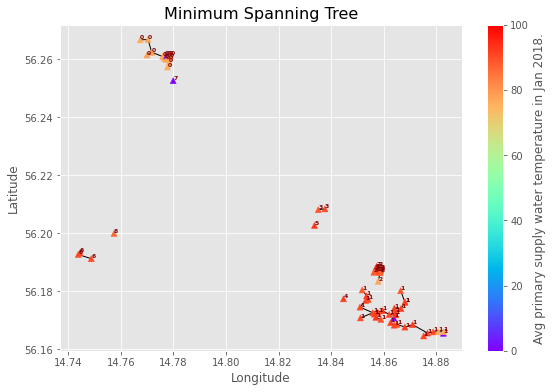

In [14]:
from mst_clustering import MSTClustering

model = MSTClustering(cutoff_scale=0.5, metric=distance_cal, approximate=False)
labels = model.fit_predict(seeds)
plot_mst_(results, 'Jan 2018.', model)

In [13]:
no_mst_labels = model.labels_
no_mst_clusters = len(set(model.labels_))
print(no_mst_clusters)

9


In [40]:
df = pd.read_csv('substations_data_drop_missing.csv', index_col=[0,1,2], parse_dates=True)
df2 = df.sort_index()

df2['cluster'] = -2
df2['exemplar'] = 0
out_t = []

for k in df2.index.levels[0]:
    df3 = df2.loc[pd.IndexSlice[(k,'outdoor_temp')]]
    t = []
    for index, row in df3.iterrows():  
        t.append(row.mean())
    out_t.extend(t * 12)
df2['outdoor_temp'] = out_t

In [14]:
def dist_matrix(x,y, dist):
    a = pd.DataFrame(0.0, index=range(len(x)), columns=range(len(y)))
    
    if len(x) == len(y):
        for i in range(len(x)):
            for j in range(i+1, len(y)):
                dist_ = dtw(x[i], y[j], window_size=1)#distance
                norm_dist_ = np.sqrt(dist_.distance)/len(dist_.path)
                a.iat[i,j]= norm_dist_
                a.iat[j,i]= norm_dist_
    else:
        temp = []
        temp_1 = []
        for i in range(len(x)):
            for j in range(len(y)):
                dist_ = dtw(x[i], y[j], window_size=1)#distance
                norm_dist_ = np.sqrt(dist_.distance)/len(dist_.path)
                temp.append(norm_dist_)
            temp_1.append(temp)
            temp = []
        a = pd.DataFrame(temp_1)

    return a.values

In [15]:
from sklearn.preprocessing import StandardScaler
def zscore_(df):
    df_zscore = []
    for item in df: 
        df_zscore.append(StandardScaler().fit_transform(item.reshape(-1,1)).reshape(1,-1)[0])
    return df_zscore

In [41]:
euclidean_norm = lambda x, y: np.abs(x - y)

threshold = 10

selected_column = ['meter_prim_supply_temp',
                   'meter_prim_return_temp',
                   'meter_effect',
                   'meter_volume_flow',
                   'prim_delta_t',
                   'gradenkeit',
                   'station_efficiency_temp',
                   'station_energy_flow']

d_1 ={}
d_2 ={}
d_3 ={}

count = 1
year = ['2015','2016','2017','2018']


for y in year:
    print(y)
    d_2 = {}
    for c in selected_column:
        d_1 = {}
        for t in [-threshold, threshold]:
            dists = []
            substat = []
            for k in df2.index.levels[0]:
                try:
                    if t > 0:
                        df3 = df2[df2['outdoor_temp'] >= threshold].loc[pd.IndexSlice[(k,c)]]   
                    else:
                        df3 = df2[df2['outdoor_temp'] < threshold].loc[pd.IndexSlice[(k,c)]]
                
                    df3_z_score = zscore_(df3[map(str,list(range(24)))].loc[str(y)].values)
                    dists.append(dist_matrix(df3_z_score, df3_z_score, euclidean_norm))
                    substat.append(k)
                
                except:
                    print('Something went wrong:', y, c, t, k)
                
                if count % 10 == 0:
                    print(count)
                count += 1
                    
            d_1.update({str(t): dict(zip(substat,dists))})
        d_2.update({c:d_1})
    d_3.update({y:d_2})


In [17]:
pickle_out = open("dict_noda.pickle","wb")
pickle.dump(d_3, pickle_out)
pickle_out.close()

In [19]:
pickle_in = open("dict_noda.pickle","rb")
d_3 = pickle.load(pickle_in)

In [16]:
# Affinity Propagation params
params = {'damping': .5,
          'affinity' : 'precomputed'
          }

In [21]:
def exemplars_feature_1(all_clusters):   
    info = []
    exemplars = []
    freq = []
    avg_features = []
    med_features = []

    for i in range(len(all_clusters)):
        for s in all_clusters[i]:
            y = s[0]
            c = s[1]
            t = s[2]
            k = s[3][1]

    #         print(y,c,t,k)

            if t > 0:
                df3 = df2[df2['outdoor_temp'] >= threshold].loc[pd.IndexSlice[(k,c)]]   
            else:
                df3 = df2[df2['outdoor_temp'] < threshold].loc[pd.IndexSlice[(k,c)]]

            avg_exemplars =[]

            for e in s[5]:
                info.append([y,c,t,k,i])
                exemplars.append(df3[map(str,list(range(24)))].loc[str(y)].values[e])
                avg_exemplars.append(df3[map(str,list(range(24)))].loc[str(y)].values[e].mean())

            avg_features.append(pd.DataFrame(avg_exemplars).mean()[0])
            med_features.append(pd.DataFrame(avg_exemplars).median()[0])

            for name, group in pd.DataFrame(s[4]).groupby(0):
                freq.append(len(group))

    info = pd.DataFrame(info)
    info.columns = ['year', c, 'outdoorTemp','substation','mst_cluster']

    freq = pd.DataFrame(freq)
    freq.columns = ['freq']

    exemplars = pd.DataFrame(exemplars)
    exemplars.columns = map(str,list(range(24)))
    return (pd.concat([info, freq, exemplars],  axis=1), avg_features, med_features)

In [22]:
def exemplars_feature_2(all_clusters):   
    info = []
    exemplars = []
    freq = []
    avg_features = []
    med_features = []

    for i in range(len(all_clusters)):
        for s in all_clusters[i]:
            y = s[0]
            c = s[1]
            t = s[2]
            k = s[3][1]
            ii = s[-1]

    #         print(y,c,t,k)

            if t > 0:
                df3 = df2[df2['outdoor_temp'] >= threshold].loc[pd.IndexSlice[(k,c)]]   
            else:
                df3 = df2[df2['outdoor_temp'] < threshold].loc[pd.IndexSlice[(k,c)]]

            avg_exemplars =[]

            for e in s[5]:
                info.append([y,c,t,k,s[3][0],ii])
                exemplars.append(df3[map(str,list(range(24)))].loc[str(y)].values[e])
                avg_exemplars.append(df3[map(str,list(range(24)))].loc[str(y)].values[e].mean())

            avg_features.append(pd.DataFrame(avg_exemplars).mean()[0])
            med_features.append(pd.DataFrame(avg_exemplars).median()[0])

            for name, group in pd.DataFrame(s[4]).groupby(0):
                freq.append(len(group))

    info = pd.DataFrame(info)
    info.columns = ['year', c, 'outdoorTemp','substation','mst_cluster','cluster_1']

    freq = pd.DataFrame(freq)
    freq.columns = ['freq']

    exemplars = pd.DataFrame(exemplars)
    exemplars.columns = map(str,list(range(24)))
    return (pd.concat([info, freq, exemplars],  axis=1), avg_features, med_features)

In [23]:
def cluster_similarity_feature_1(exemplars, avg_features, med_features):
    np.random.seed(101)
    b = []
    for name, group in exemplars.groupby('mst_cluster'):
        
        substations = group['substation'].unique()
        print('MST_cluster: ',name, '\nNo. of substations:', len(substations))

        a = pd.DataFrame(0.0, 
                         index=range(len(substations)), 
                         columns=range(len(substations))
                        )
        for k in range(len(substations)):
            for j in range(k+1, len(substations)):

                temp_1 = pd.DataFrame(dist_matrix(
                        zscore_(group[group['substation'] == substations[k]][map(str,list(range(24)))].values),
                        zscore_(group[group['substation'] == substations[j]][map(str,list(range(24)))].values),
                        euclidean_norm))

                temp_2 = []
                temp_2.append(list(group[group['substation'] == substations[k]]['freq']))
                temp_2.append(list(group[group['substation'] == substations[j]]['freq']))

                sum_1 = 0

                for i in range(temp_1.shape[0]):
                    sum_1 += temp_2[0][i] / sum(temp_2[0]) * temp_1.loc[i].min()

                sum_2 = 0
                for i in range(temp_1.shape[1]):
                    sum_2 += temp_2[1][i] / sum(temp_2[1]) * temp_1[i].min()

                a.iat[k,j] = (sum_1 + sum_2)/2
                a.iat[j,k] = a.iat[k,j]

        if max(a.isna().sum()) == 0:
            if max(a.sum()/(a.shape[0] - 1)) - min(a.sum()/(a.shape[0] - 1)) > 0.0:
                af = AffinityPropagation(damping = params['damping'], 
                                     affinity = params['affinity'])


                af.fit(a)
                labels = af.labels_
                is_exemplar = [0]*len(substations)
                    
                for ii in af.cluster_centers_indices_:
                    is_exemplar[ii] = 1
                print('No. of clusters:', len(af.cluster_centers_indices_))
                print()
            else:
                labels = [0] * a.shape[0]
                is_exemplar = [0]*len(substations)
                is_exemplar[randint(0, len(is_exemplar)-1)] = 1
                print('No. of clusters:', 1)
                print()

        else:
            print(k, ' has nan values.')
            print('No. of clusters:', len(af.cluster_centers_indices_))

        for g, h, avg_f, med_f, ex in zip(substations, labels, avg_features, med_features, is_exemplar):
            b.append([y, g, c, avg_f, med_f, t, name, h, ex])

    return pd.DataFrame(b)

In [24]:
def cluster_similarity_feature_2(exemplars, avg_features, med_features):
    np.random.seed(101)
    b = []
    for name, group in exemplars.groupby('mst_cluster'):
        for _ in group['cluster_1'].unique():
            
            substations = group[group['cluster_1'] == _]['substation'].unique()
            print('MST_cluster: ',name, '\nNo. of substations:', len(substations))

            a = pd.DataFrame(0.0, 
                             index=range(len(substations)), 
                             columns=range(len(substations))
                            )
            for k in range(len(substations)):
                for j in range(k+1, len(substations)):

                    temp_1 = pd.DataFrame(dist_matrix(
                            zscore_(group[group['cluster_1'] == _][group[group['cluster_1'] == _]['substation'] == substations[k]][map(str,list(range(24)))].values),
                            zscore_(group[group['cluster_1'] == _][group[group['cluster_1'] == _]['substation'] == substations[j]][map(str,list(range(24)))].values),
                            euclidean_norm))

                    temp_2 = []
                    temp_2.append(list(group[group['cluster_1'] == _][group[group['cluster_1'] == _]['substation'] == substations[k]]['freq']))
                    temp_2.append(list(group[group['cluster_1'] == _][group[group['cluster_1'] == _]['substation'] == substations[j]]['freq']))
                    
                    sum_1 = 0

                    for i in range(temp_1.shape[0]):
                        sum_1 += temp_2[0][i] / sum(temp_2[0]) * temp_1.loc[i].min()

                    sum_2 = 0
                    for i in range(temp_1.shape[1]):
                        sum_2 += temp_2[1][i] / sum(temp_2[1]) * temp_1[i].min()

                    a.iat[k,j] = (sum_1 + sum_2)/2
                    a.iat[j,k] = a.iat[k,j]


            if max(a.isna().sum()) == 0:
                if max(a.sum()/(a.shape[0] - 1)) - min(a.sum()/(a.shape[0] - 1)) > 0.0:
                    af = AffinityPropagation(damping = params['damping'], 
                                         affinity = params['affinity'])


                    af.fit(a)
                    labels = af.labels_
                    is_exemplar = [0]*len(substations)
                    
                    for ii in af.cluster_centers_indices_:
                        is_exemplar[ii] = 1
                    print('No. of clusters:', len(af.cluster_centers_indices_))
                    print()
                else:
                    labels = [0] * a.shape[0]
                    is_exemplar = [0]*len(substations)
                    is_exemplar[randint(0, len(is_exemplar)-1)] = 1
                    print('No. of clusters:', 1)
                    print()

            else:
                print(k, ' has nan values.')
                print('No. of clusters:', len(af.cluster_centers_indices_))

            for g, h, avg_f, med_f, ex_2 in zip(substations, labels, 
                                                      avg_features, med_features, 
                                                      is_exemplar):
                b.append([y, g, cc, avg_f, med_f, t, name, _, h, ex_2])

    return pd.DataFrame(b)

In [77]:
# Step-wise  multi-view  clustering  analysis
selected_column = ['meter_prim_supply_temp',
                   'meter_prim_return_temp',
                   'meter_effect',
                   'meter_volume_flow',
                   'prim_delta_t',
                   'sec_delta_t',
                   'gradenkeit',
                   'station_efficiency_temp'
                  ]


bbb = pd.DataFrame()
np.random.seed(101)
t = -threshold
neighbour_substations = []
    
for i in range(no_mst_clusters):
    for k,l in zip(df2.index.levels[0], no_mst_labels):
        if i == l:
            neighbour_substations.append([i,k])

year = ['2015','2016','2017','2018']

for c in selected_column:
    print(c)
    selected_column_without_current_one = list(selected_column)
    selected_column_without_current_one.remove(c)
    
    for y in year:
        b = pd.DataFrame()
        all_clusters_1 = []
        for name, group in pd.DataFrame(neighbour_substations).groupby(0):
            cluster_info = []
            for k in group[1]:
                try:
                    af = AffinityPropagation(damping = params['damping'], 
                                             affinity = params['affinity'])
                    af.fit(d_3[y][c][str(t)][k])
                    cluster_info.append([y, c, t, [name, k], af.labels_, af.cluster_centers_indices_])
                except:
                    print('{} does not have any record in {}'.format(k,y))
                
            all_clusters_1.append(cluster_info)
            
        ######################################################################################
        exemplars_1, avg_features, med_features = exemplars_feature_1(all_clusters_1)
        b = pd.concat([b, cluster_similarity_feature_1(exemplars_1, avg_features, med_features)]
                     ,sort=False)
        b.columns = ['year',
                     'substation',
                     'feature_1',
                     'avg_feature_1',
                     'med_feature_1',
                     'outdoor_temp',
                     'mst_cluster',
                     'cluster_1',
                     'exemplar_1']
        ######################################################################################
        
        for cc in selected_column_without_current_one:
            bb = pd.DataFrame()
            for name, group in b[b['year'] == y].groupby('mst_cluster'):
                all_clusters_2 = []
                print(name, cc)
                for i in group['cluster_1'].unique():

                    substations = group[group['cluster_1'] == i]['substation']
                    cluster_info = []

                    for k in substations:
                        try:
                            af = AffinityPropagation(damping = params['damping'], 
                                                     affinity = params['affinity'])
                            af.fit(d_3[y][cc][str(t)][k])
                            cluster_info.append([y, cc, t, [name, k], af.labels_, af.cluster_centers_indices_, i])
                        except:
                            print('{} does not have any record in {}'.format(k,y))

                    all_clusters_2.append(cluster_info)

            # ######################################################################################
                if len(selected_column_without_current_one) > 0:
                    exemplars_2, avg_features, med_features = exemplars_feature_2(all_clusters_2)
                    bb = pd.concat([bb, cluster_similarity_feature_2(exemplars_2, avg_features, med_features)]
                                   ,sort=False)
            
            if len(bb.index) > 0:
                df___1=b.set_index('substation')
                df___2=bb.set_index(1)
                df___3 = pd.concat([df___1, df___2], axis=1, sort=False).reindex(df___1.index)
                df___3.drop(columns= ['outdoor_temp',
                                      'mst_cluster',
                                      'cluster_1',
                                      0], inplace=True)
                df___3.reset_index(inplace=True)
                df___3.set_index('year',inplace=True)
                df___3.reset_index(inplace=True)
                bbb = pd.concat([bbb, df___3]
                                ,sort=False)
        ######################################################################################
bbb.columns =['year',
              'substation',
              'feature_1',
              'avg_feature_1',
              'med_feature_1',
              'exemplar_1',
              'feature_2',
              'avg_feature_2', 
              'med_feature_2',
              'outdoor_temp',
              'mst_cluster',
              'cluster_1',
              'cluster_2',
              'exemplar_2']

bbb = bbb[['year',
           'substation',
           'feature_1',
           'avg_feature_1',
           'med_feature_1',
           'feature_2',
           'avg_feature_2', 
           'med_feature_2',
           'outdoor_temp',
           'mst_cluster',
           'cluster_1',
           'exemplar_1',
           'cluster_2',
           'exemplar_2']]

bbb.to_csv('step-wise_analysis_2015-2018_'+ str(no_mst_clusters)+'_'+ str(params['damping']).replace('.','_') +'.csv')

meter_prim_supply_temp
MST_cluster:  0 
No. of substations: 15
No. of clusters: 2

MST_cluster:  1 
No. of substations: 32
No. of clusters: 3

MST_cluster:  2 
No. of substations: 14
No. of clusters: 3

MST_cluster:  3 
No. of substations: 2
No. of clusters: 1

MST_cluster:  4 
No. of substations: 1
No. of clusters: 1

MST_cluster:  5 
No. of substations: 1
No. of clusters: 1

MST_cluster:  6 
No. of substations: 3
No. of clusters: 1

MST_cluster:  7 
No. of substations: 1
No. of clusters: 1

MST_cluster:  8 
No. of substations: 1
No. of clusters: 1

0 meter_prim_return_temp
MST_cluster:  0 
No. of substations: 7
No. of clusters: 2

MST_cluster:  0 
No. of substations: 8
No. of clusters: 2

1 meter_prim_return_temp
MST_cluster:  1 
No. of substations: 7
No. of clusters: 3

MST_cluster:  1 
No. of substations: 16
No. of clusters: 2

MST_cluster:  1 
No. of substations: 9
No. of clusters: 1
...


In [ ]:
# Parallel-wise multi-view clustering analysis

np.random.seed(101)
t = -threshold
neighbour_substations = []
year = ['2015','2016','2017','2018']


for i in range(no_mst_clusters):
    for k,l in zip(df2.index.levels[0], no_mst_labels):
        if i == l:
            neighbour_substations.append([i,k])



for c in selected_column:
    b = []
    
    for y in year:

        all_clusters = []
        cluster_info = []

        for name, group in pd.DataFrame(neighbour_substations).groupby(0):
            for k in group[1]:
                try:
                    af = AffinityPropagation(damping = params['damping'], 
                                             affinity = params['affinity']
                                            )
                    af.fit(d_3[y][c][str(t)][k])
                    cluster_info.append([y, c, t, [name, k], af.labels_, af.cluster_centers_indices_])
                except:
                    print('{} does not have any record in {}'.format(k,y))
            all_clusters.append(cluster_info)
            cluster_info = []

        ######################################################################################

        info = []
        exemplars = []
        freq = []
        avg_features = []
        med_features = []

        for i in range(len(all_clusters)):
            for s in all_clusters[i]:
                y = s[0]
                c = s[1]
                t = s[2]
                k = s[3][1]

                
                if t > 0:
                    df3 = df2[df2['outdoor_temp'] >= threshold].loc[pd.IndexSlice[(k,c)]]   
                else:
                    df3 = df2[df2['outdoor_temp'] < threshold].loc[pd.IndexSlice[(k,c)]]
                
                avg_exemplars =[]
                
                for e in s[5]:  
                    info.append([y,c,t,k,i])
                    exemplars.append(df3[map(str,list(range(24)))].loc[str(y)].values[e])
                    avg_exemplars.append(df3[map(str,list(range(24)))].loc[str(y)].values[e].mean())
                
                avg_features.append(pd.DataFrame(avg_exemplars).mean()[0])
                med_features.append(pd.DataFrame(avg_exemplars).median()[0])
                
                for name, group in pd.DataFrame(s[4]).groupby(0):
                    freq.append(len(group))

        info = pd.DataFrame(info)
        info.columns = ['year', c, 'outdoorTemp','substation','mst_cluster']

        freq = pd.DataFrame(freq)
        freq.columns = ['freq']

        exemplars = pd.DataFrame(exemplars)
        exemplars.columns = map(str,list(range(24)))
        exemplars = pd.concat([info, freq, exemplars],  axis=1)

        ###################################################################################### 

        temp = []
        output =[]

        for i,j in enumerate(data[data[3] == y][0].unique()):
            temp.append(j)
            output.append([i, np.inf, j])

        for name, group in exemplars.groupby('mst_cluster'):
            
            substations = group['substation'].unique()
            print('MST_cluster: ',name, ' No. of substations:', len(substations))

            a = pd.DataFrame(0.0, 
                             index=range(len(substations)), 
                             columns=range(len(substations))
                            )
            
            for k in range(len(substations)):
                for j in range(k+1, len(substations)):
                    
                    temp_1 = pd.DataFrame(dist_matrix(
                            zscore_(group[group['substation'] == substations[k]][map(str,list(range(24)))].values),
                            zscore_(group[group['substation'] == substations[j]][map(str,list(range(24)))].values),
                            euclidean_norm))

                    temp_2 = []
                    temp_2.append(list(group[group['substation'] == substations[k]]['freq']))
                    temp_2.append(list(group[group['substation'] == substations[j]]['freq']))

                    sum_1 = 0
                    for i in range(temp_1.shape[0]):
                        sum_1 += temp_2[0][i] / sum(temp_2[0]) * temp_1.loc[i].min()

                    sum_2 = 0
                    for i in range(temp_1.shape[1]):
                        sum_2 += temp_2[1][i] / sum(temp_2[1]) * temp_1[i].min()

                    a.iat[k,j] = (sum_1 + sum_2 )/2
                    a.iat[j,k] = a.iat[k,j]

            if max(a.isna().sum()) == 0:
                if max(a.sum()/(a.shape[0] - 1)) - min(a.sum()/(a.shape[0] - 1)) > 0.0:
                    af = AffinityPropagation(damping = params['damping'], 
                                         affinity = params['affinity'])


                    af.fit(a)
                    labels = af.labels_
                    is_exemplar = [0]*len(substations)
                    
                    for ii in af.cluster_centers_indices_:
                        is_exemplar[ii] = 1
                    print('No. of clusters:', len(af.cluster_centers_indices_))
                    print()
                else:
                    labels = [0] * a.shape[0]
                    is_exemplar = [0]*len(substations)
                    is_exemplar[randint(0, len(is_exemplar)-1)] = 1
                    print('No. of clusters:', 1)
                    print()
                    
            else:
                print(k, ' has nan values.')
                print('No. of clusters:', len(af.cluster_centers_indices_))

            for g, h, avg_f, med_f, ex in zip(substations, labels, avg_features, med_features, is_exemplar):
                b.append([y, g, c, avg_f, med_f, t, name, h, ex])

    b = pd.DataFrame(data = b, 
                    columns = ['year','substation','feature','avg_feature', 'med_feature', 'outdoor_temp','mst_cluster', 'cluster', 'exemplar'])
    
    b.to_csv('clustering_results_'+ c +'_2015-2018_'+ str(no_mst_clusters)+'_'+ str(params['damping']).replace('.','_') +'.csv')

MST_cluster:  0  No. of substations: 15
No. of clusters: 2

MST_cluster:  1  No. of substations: 32
No. of clusters: 3

MST_cluster:  2  No. of substations: 14
No. of clusters: 3

MST_cluster:  3  No. of substations: 2
No. of clusters: 1

MST_cluster:  4  No. of substations: 1
No. of clusters: 1

MST_cluster:  5  No. of substations: 1
No. of clusters: 1

MST_cluster:  6  No. of substations: 3
No. of clusters: 1

MST_cluster:  7  No. of substations: 1
No. of clusters: 1

MST_cluster:  8  No. of substations: 1
No. of clusters: 1

MST_cluster:  0  No. of substations: 15
No. of clusters: 1

MST_cluster:  1  No. of substations: 32
No. of clusters: 2

MST_cluster:  2  No. of substations: 14
No. of clusters: 2

MST_cluster:  3  No. of substations: 2
No. of clusters: 1

MST_cluster:  4  No. of substations: 1
No. of clusters: 1

MST_cluster:  5  No. of substations: 1
No. of clusters: 1

MST_cluster:  6  No. of substations: 3
No. of clusters: 1

MST_cluster:  7  No. of substations: 1
No. of clus

In [17]:
# ARI
no_mst_c = str(no_mst_clusters)
af_damp = str(params['damping']).replace('.','_')

PS=pd.read_csv('clustering_results_meter_prim_supply_temp_2015-2018_'+ no_mst_c + '_' + af_damp +'.csv', header=0, index_col=1, parse_dates=True).drop(columns=['Unnamed: 0'])
PS.sort_values('substation', inplace=True)

PR=pd.read_csv('clustering_results_meter_prim_return_temp_2015-2018_'+ no_mst_c + '_' + af_damp +'.csv', header=0, index_col=1, parse_dates=True).drop(columns=['Unnamed: 0'])
PR.sort_values('substation', inplace=True)

E=pd.read_csv('clustering_results_meter_effect_2015-2018_'+ no_mst_c + '_' + af_damp +'.csv', header=0, index_col=1, parse_dates=True).drop(columns=['Unnamed: 0'])
E.sort_values('substation', inplace=True)

VF=pd.read_csv('clustering_results_meter_volume_flow_2015-2018_'+ no_mst_c + '_' + af_damp +'.csv', header=0, index_col=1, parse_dates=True).drop(columns=['Unnamed: 0'])
VF.sort_values('substation', inplace=True)

Delta_Sec_PS_PR=pd.read_csv('clustering_results_sec_delta_t_2015-2018_'+ no_mst_c + '_' + af_damp +'.csv', header=0, index_col=1, parse_dates=True).drop(columns=['Unnamed: 0'])
Delta_Sec_PS_PR.sort_values('substation', inplace=True)

Delta_Pri_PS_PR=pd.read_csv('clustering_results_prim_delta_t_2015-2018_'+ no_mst_c + '_' + af_damp +'.csv', header=0, index_col=1, parse_dates=True).drop(columns=['Unnamed: 0'])
Delta_Pri_PS_PR.sort_values('substation', inplace=True)

Gradenkeit=pd.read_csv('clustering_results_gradenkeit_2015-2018_'+ no_mst_c + '_' + af_damp +'.csv', header=0, index_col=1, parse_dates=True).drop(columns=['Unnamed: 0'])
Gradenkeit.sort_values('substation', inplace=True)

Efficiency=pd.read_csv('clustering_results_station_efficiency_temp_2015-2018_'+ no_mst_c + '_' + af_damp +'.csv', header=0, index_col=1, parse_dates=True).drop(columns=['Unnamed: 0'])
Efficiency.sort_values('substation', inplace=True)

In [24]:
# ARI
from sklearn.metrics.cluster import adjusted_rand_score
tmp = []
feature_df = [PR, Delta_Pri_PS_PR, Delta_Sec_PS_PR, PS, Gradenkeit, Efficiency , E, VF]
year = ['2015','2016','2017','2018']
for y in year:
    for f_1 in range(len(feature_df)):
        for f_2 in range(f_1 + 1, len(feature_df)):
            pairs = (feature_df[f_1]['feature'][0], feature_df[f_2]['feature'][0])
            sum_ari = 0
            for name, group in feature_df[f_1].loc[y].groupby('mst_cluster'):

                b=feature_df[f_2][feature_df[f_2]['mst_cluster'] == name]
                ari = adjusted_rand_score(group['cluster'].values, b.loc[y,'cluster'].values)
                sum_ari = sum_ari + ari
                tmp.append([y,
                            pairs,
                            0,
                            name,
                            len(group),
                            ari])
tmp = pd.DataFrame(data=tmp, columns=['year','features', 'overal','mst_cluster', 'no_members' , 'adjusted_rand_score'])     

In [25]:
tmp_1 = []
tmp_2 = []
col = []

for i, j in enumerate(tmp[tmp['year'] == '2015'].no_members):
    if i <= no_mst_clusters - 1:
        col.append((i,j))
    else: 
        break

for name, group in tmp.groupby('year', sort=False):
    for name_1, group_1 in group.groupby('features', sort=False):
        tmp_1.append([name, name_1])
        tmp_2.append(group_1.adjusted_rand_score.T.values)
tmp_1 = pd.DataFrame(tmp_1, columns = ['year', 'features'])
tmp_2 = pd.DataFrame(tmp_2, columns = col)
tmp_3 = pd.concat([tmp_1, tmp_2], axis=1, sort=False)

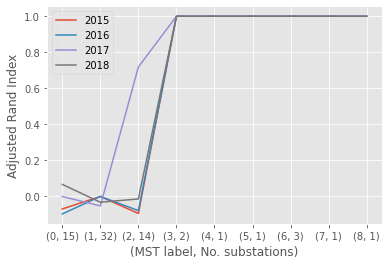

In [26]:
for name, group in tmp_3.groupby('features',sort=False):
    
    tmp_4 = group.drop(['year','features'], axis=1).T
    tmp_4 = tmp_4.rename(columns={tmp_4.columns[0]:'2015',tmp_4.columns[1]:'2016',
                      tmp_4.columns[2]:'2017',tmp_4.columns[3]:'2018'})
    tmp_4.plot(figsize=(6,4))
    plt.xlabel('(MST label, No. substations)')
    plt.ylabel('Adjusted Rand Index')
#     plt.savefig('PR-Delta-Rand.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [28]:
tmp = []
feature_df = [PR, Delta_Pri_PS_PR, Delta_Sec_PS_PR, PS, Gradenkeit, Efficiency, E, VF]
for y in year:
    for f_1 in range(len(feature_df)):
        for f_2 in range(f_1 + 1, len(feature_df)):
            pairs = (feature_df[f_1]['feature'][0], feature_df[f_2]['feature'][0])
            if pairs == ('meter_prim_return_temp', 'prim_delta_t'):
                sum_ari = 0
                ind = []
                for name, group in feature_df[f_1].loc[y].groupby('mst_cluster', sort=False):
                    

                    b=feature_df[f_2][feature_df[f_2]['mst_cluster'] == name].loc[y]

                    print(adjusted_rand_score(group['cluster'],b['cluster']))
                    for i in set(group['cluster']):
                        for j in set(b['cluster']):
                            if i == j:
                                print(len(set(group[group['cluster'] == i]['substation']).intersection(set(b[b['cluster'] == j]['substation']))))
                                print(name, i, j ,set(group[group['cluster'] == i]['substation']).intersection(set(b[b['cluster'] == j]['substation'])))
                                for ii in set(group[group['cluster'] == i]['substation']).intersection(set(b[b['cluster'] == j]['substation'])):

                                    for index, row in results[0].items():
                                        if row == ii:
                                            ind.append(index)
                                            break
                tmp.append([y, pairs, name, ind])
                

In [29]:
tmp = []
feature_df = [PR, Delta_Pri_PS_PR]
for y in ['2017']:
    for f_1 in range(len(feature_df)):
        for f_2 in range(f_1 + 1, len(feature_df)):
            pairs = (feature_df[f_1]['feature'][0], feature_df[f_2]['feature'][0])
            if pairs == ('meter_prim_return_temp', 'prim_delta_t'):
                for name, group in feature_df[f_1].loc[y].groupby('mst_cluster', sort=False):
                    print(y,name)
                    b=feature_df[f_2][feature_df[f_2]['mst_cluster'] == name]
                    
                    print(feature_df[f_1]['feature'][0])
                    for name_, group_ in group.groupby('cluster'):
                        print('    ', name_, len(group_) ,round(group_['avg_feature'].mean(),2), 
                              round(group_['avg_feature'].std(),2))
                        
                    print(feature_df[f_2]['feature'][0])
                    for name_, group_ in b.loc[y].groupby('cluster'): 
                        print('    ', name_, len(group_), round(group_['avg_feature'].mean(),2), 
                              round(group_['avg_feature'].std(),2))

2017 0
meter_prim_return_temp
     0 8 43.31 5.39
     1 1 47.88 nan
     2 5 46.23 3.35
     3 1 47.61 nan
prim_delta_t
     0 15 34.5 4.6
2017 1
meter_prim_return_temp
     0 11 43.23 5.75
     1 4 40.05 6.1
     2 16 42.71 3.85
     3 1 37.53 nan
prim_delta_t
     0 10 40.46 9.71
     1 22 44.77 9.84
2017 2
meter_prim_return_temp
     0 2 43.61 0.43
     1 9 43.54 4.02
     2 3 48.81 6.74
prim_delta_t
     0 10 35.4 4.21
     1 4 32.6 6.12
2017 3
meter_prim_return_temp
     0 2 41.36 2.75
prim_delta_t
     0 2 37.27 4.26
2017 4
meter_prim_return_temp
     0 1 43.3 nan
prim_delta_t
     0 1 34.25 nan
2017 5
meter_prim_return_temp
     0 1 43.3 nan
prim_delta_t
     0 1 34.25 nan
2017 6
meter_prim_return_temp
     0 3 41.07 2.0
prim_delta_t
     0 3 38.27 3.48
2017 7
meter_prim_return_temp
     0 1 43.3 nan
prim_delta_t
     0 1 34.25 nan
2017 8
meter_prim_return_temp
     0 1 43.3 nan
prim_delta_t
     0 1 34.25 nan


('meter_prim_return_temp', 'prim_delta_t')


<IPython.core.display.Javascript object>


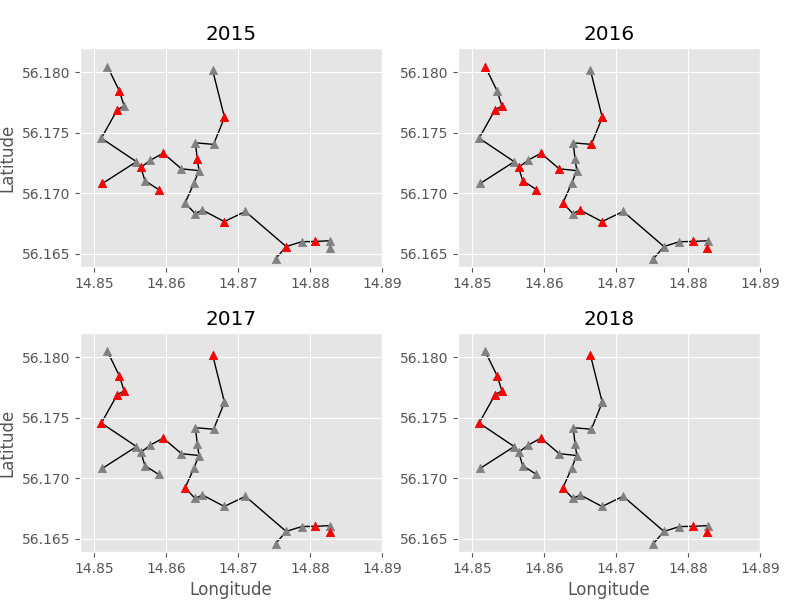

In [734]:
%matplotlib notebook
        
print(tmp[0][1])
plt.figure(figsize=(8,6))

ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(2,2,3, sharex=ax1, sharey=ax1)
ax4 = plt.subplot(2,2,4, sharex=ax1, sharey=ax1)


loc_0= []
for index in tmp[0][3]:
    for i,j in enumerate(seeds):
        if i == index:
            loc_0.append(j)
    
segments = model.get_graph_segments(full_graph=False)
ax1.plot(segments[1],
         segments[0],
         '-k',
         zorder=-1,
         lw=1)

ax1.scatter(seeds[:, 1],seeds[:, 0], marker = '^', c = 'grey');
ax1.scatter(np.array(loc_0)[:, 1],np.array(loc_0)[:, 0], marker = '^', c = 'r');
ax1.set_ylabel('Latitude')
ax1.set_title(str(year[0]))

loc_0= []
for index in tmp[1][3]:
    for i,j in enumerate(seeds):
        if i == index:
            loc_0.append(j)
    
segments = model.get_graph_segments(full_graph=False)
ax2.plot(segments[1],
         segments[0],
         '-k',
         zorder=-1,
         lw=1)

ax2.scatter(seeds[:, 1],seeds[:, 0], marker = '^', c = 'grey');
ax2.scatter(np.array(loc_0)[:, 1],np.array(loc_0)[:, 0], marker = '^', c = 'r');
ax2.set_title(str(year[1]))

loc_0= []
for index in tmp[3][3]:
    for i,j in enumerate(seeds):
        if i == index:
            loc_0.append(j)
    
segments = model.get_graph_segments(full_graph=False)
ax3.plot(segments[1],
         segments[0],
         '-k',
         zorder=-1,
         lw=1)

ax3.scatter(seeds[:, 1],seeds[:, 0], marker = '^', c = 'grey');
ax3.scatter(np.array(loc_0)[:, 1],np.array(loc_0)[:, 0], marker = '^', c = 'r');
ax3.set_ylabel('Latitude')
ax3.set_xlabel('Longitude')
ax3.set_title(str(year[2]))


loc_0= []
for index in tmp[3][3]:
    for i,j in enumerate(seeds):
        if i == index:
            loc_0.append(j)

segments = model.get_graph_segments(full_graph=False)
ax4.plot(segments[1],
         segments[0],
         '-k',
         zorder=-1,
         lw=1)

ax4.scatter(seeds[:, 1],seeds[:, 0], marker = '^', c = 'grey');
ax4.scatter(np.array(loc_0)[:, 1],np.array(loc_0)[:, 0], marker = '^', c = 'r');
ax4.set_xlim([14.848, 14.89])
ax4.set_ylim([56.1639,56.182])
ax4.set_xlabel('Longitude')
ax4.set_title(str(year[3]))

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3,
                wspace=0.25)
plt.savefig('PR-Delta-2.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [31]:
no_mst_c = str(no_mst_clusters)
af_damp = str(params['damping']).replace('.','_')

b = pd.read_csv('step-wise_analysis_2015-2018_'+ no_mst_c + '_' + af_damp +'.csv', 
                header=0, 
                index_col=1, 
                parse_dates=True).drop(columns=['Unnamed: 0'])

f_1 = 'meter_prim_return_temp'

f_2 = 'prim_delta_t'

tmp_2015_ = b[(b['feature_1'] == f_2) & (b['feature_2'] == f_1)].loc['2015']
tmp_2015_.sort_values('substation', inplace=True)
tmp_2016_ = b[(b['feature_1'] == f_2) & (b['feature_2'] == f_1)].loc['2016']
tmp_2016_.sort_values('substation', inplace=True)
tmp_2017_ = b[(b['feature_1'] == f_2) & (b['feature_2'] == f_1)].loc['2017']
tmp_2017_.sort_values('substation', inplace=True)
tmp_2018_ = b[(b['feature_1'] == f_2) & (b['feature_2'] == f_1)].loc['2018']
tmp_2018_.sort_values('substation', inplace=True)


tmp_2015 = b[(b['feature_1'] == f_1) & (b['feature_2'] == f_2)].loc['2015']
tmp_2015.sort_values('substation', inplace=True)
tmp_2016 = b[(b['feature_1'] == f_1) & (b['feature_2'] == f_2)].loc['2016']
tmp_2016.sort_values('substation', inplace=True)
tmp_2017 = b[(b['feature_1'] == f_1) & (b['feature_2'] == f_2)].loc['2017']
tmp_2017.sort_values('substation', inplace=True)
tmp_2018 = b[(b['feature_1'] == f_1) & (b['feature_2'] == f_2)].loc['2018']
tmp_2018.sort_values('substation', inplace=True)

In [33]:
ll=[tmp_2015, 
    tmp_2016, 
    tmp_2017, 
    tmp_2018, 
   ]


for l in ll:
    l['color_1'] = 1
    l['color_2'] = 1
    tmp_1 = []
    tmp_2 = []
    for name, group in l.groupby('mst_cluster'):
        for name_, group_ in group.groupby('cluster_1'):
            if len(group_) > 1:
                print(name, name_, ' ', round(group_['avg_feature_1'].mean(),4), 
                      round(group_['avg_feature_1'].std(),4))
            else:
                print(name, name_, ' ', round(group_['avg_feature_1'].mean(),4), 
                      round(group_['avg_feature_1'].std(),4))    
                
            for i in group_['substation']:
                l.loc[l['substation'] == i, 'color_1'] = round(group_['avg_feature_1'].mean(),4)

            for name__, group__ in group_.groupby('cluster_2'):
                if len(group__) > 1:
                    print('   ', name__, round(group__['avg_feature_2'].mean(),4), 
                      round(group__['avg_feature_2'].std(),4))
                else:
                    print('   ', name__, round(group__['avg_feature_2'].mean(),4), 
                          round(group__['avg_feature_2'].std(),4))

                
                for i in group__['substation']:
                    l.loc[l['substation'] == i, 'color_2'] = round(group__['avg_feature_2'].mean(),4)
        
    print('__________________________________')

0 0   44.8333 6.0382
    0 29.9726 3.2158
0 1   42.8716 3.3963
    0 28.5555 nan
    1 31.3536 3.0117
1 0   40.8304 4.6197
    0 48.9579 6.1319
    1 44.6241 9.118
    2 47.1883 6.408
2 0   41.0449 2.5456
    0 46.1791 9.4472
    1 55.4669 8.849
2 1   44.4451 4.7586
    0 49.4644 7.741
    1 55.165 5.7267
3 0   39.9935 1.4186
    0 51.0795 0.9573
4 0   38.9903 nan
    0 40.9412 nan
5 0   38.9903 nan
    0 53.6257 nan
6 0   40.4698 1.2988
    0 47.6083 9.7078
7 0   38.9903 nan
    0 27.0339 nan
8 0   38.9903 nan
    0 40.9388 nan
__________________________________
0 0   44.2138 4.4723
    0 35.4577 1.2816
0 1   45.2739 2.7475
    0 35.6671 1.1271
    1 25.1116 nan
0 2   44.618 5.3642
    0 33.9605 4.5309
1 0   42.5018 5.3718
    0 48.5438 8.5823
    1 55.216 3.3246
1 1   43.0052 3.2689
    0 49.7185 9.8881
    1 50.794 4.0834
1 2   40.9079 4.8779
    0 52.9891 4.2841
2 0   43.4993 3.1303
    0 54.0541 6.8952
2 1   46.3234 5.6628
    0 52.3349 8.6864
3 0   42.6909 2.8143
    0 52.1422 1.

12


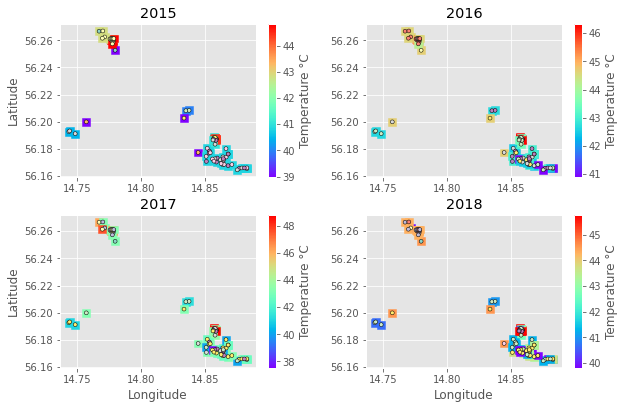

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
Set3 = cm.get_cmap('Set3')
print(Set3)
print(len(Set3.colors))

# plt.figure(figsize=(9,12))
fig, ax = plt.subplots(figsize=(9,12))

ax1 = plt.subplot(4,2,1)
ax3 = plt.subplot(4,2,2, sharex=ax1, sharey=ax1)
ax5 = plt.subplot(4,2,3, sharex=ax1, sharey=ax1)
ax7 = plt.subplot(4,2,4, sharex=ax1, sharey=ax1)

cmap = 'rainbow'
s=60

segments = model.get_graph_segments(full_graph=False)
ax1.plot(segments[1],
         segments[0],
         '-k',
         zorder=-1,
         lw=1)

joinedlist = list(tmp_2015['color_1'].values)
im = ax1.scatter(seeds[:, 1],
                 seeds[:, 0], 
                 marker = 's', 
                 c = tmp_2015['color_1'].values, 
                 cmap = cmap,
                 s = s,
                 vmin=np.min(joinedlist), 
                 vmax=np.max(joinedlist)
                );

fig.colorbar(im, ax=ax1, label='Temperature °C')

joinedlist = list(tmp_2015['color_2'].values)
ax1.scatter(seeds[:, 1],seeds[:, 0], 
            marker = '.', 
            c = tmp_2015['color_2'].values, 
            cmap = 'Set3',
            s = s,
            edgecolor='black',
            vmin=np.min(joinedlist), 
            vmax=np.max(joinedlist)
           );


ax1.set_ylabel('Latitude')
ax1.set_title(str(year[0]))

joinedlist = list(tmp_2016['color_1'].values)
segments = model.get_graph_segments(full_graph=False)
ax3.plot(segments[1],
         segments[0],
         '-k',
         zorder=-1,
         lw=1)

im=ax3.scatter(seeds[:, 1],
               seeds[:, 0], 
               marker = 's', 
               c = tmp_2016['color_1'].values, 
               cmap = cmap,
               s = s,
               vmin=np.min(joinedlist), 
               vmax=np.max(joinedlist)
              );

fig.colorbar(im,ax=ax3, label='Temperature °C')

joinedlist = list(tmp_2016['color_2'].values)
ax3.scatter(seeds[:, 1],
            seeds[:, 0], 
            marker = '.', 
            c = tmp_2016['color_2'].values,
            s = s,
            cmap = 'Set3',
            edgecolor='black',
            vmin=np.min(joinedlist), 
            vmax=np.max(joinedlist)
           );
ax3.set_title(str(year[1]))


joinedlist = list(tmp_2017['color_1'].values)
segments = model.get_graph_segments(full_graph=False)
ax5.plot(segments[1],
         segments[0],
         '-k',
         zorder=-1,
         lw=1)

im=ax5.scatter(seeds[:, 1],
               seeds[:, 0], 
               marker = 's', 
               c = tmp_2017['color_1'].values, 
               cmap = cmap,
               s = s,
               vmin=np.min(joinedlist), 
               vmax=np.max(joinedlist)
              );
fig.colorbar(im,ax=ax5, label='Temperature °C')

joinedlist = list(tmp_2017['color_2'].values)
ax5.scatter(seeds[:, 1],
            seeds[:, 0], marker = '.', 
            c = tmp_2017['color_2'].values,
            s = s,
            cmap = 'Set3',
            edgecolor='black',
            vmin=np.min(joinedlist), 
            vmax=np.max(joinedlist)
           );


ax5.set_title(str(year[2]))
ax5.set_xlabel('Longitude')
ax5.set_ylabel('Latitude')

joinedlist = list(tmp_2018['color_1'].values)
segments = model.get_graph_segments(full_graph=False)
ax7.plot(segments[1],
         segments[0],
         '-k',
         zorder=-1,
         lw=1)

im=ax7.scatter(seeds[:, 1],
               seeds[:, 0], 
               marker = 's', 
               c = tmp_2018['color_1'].values,
               s = s,
               cmap = cmap,
               vmin=np.min(joinedlist), 
               vmax=np.max(joinedlist));

fig.colorbar(im,ax=ax7, label='Temperature °C')

joinedlist = list(tmp_2018['color_2'].values)
ax7.scatter(seeds[:, 1],
            seeds[:, 0], 
            marker = '.', 
            c = tmp_2018['color_2'].values,
            s = s,
            cmap = 'Set3',
            edgecolor='black',
            vmin=np.min(joinedlist), 
            vmax=np.max(joinedlist)
           );


ax7.set_title(str(year[3]))
ax7.set_xlabel('Longitude')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                wspace=0.25)
plt.savefig('pr-delta-1.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()


12


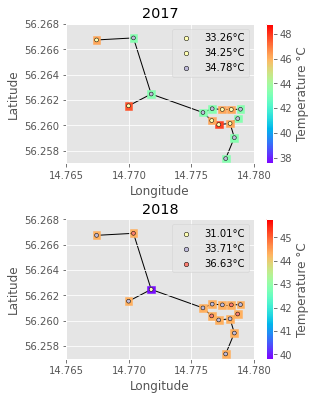

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
Set3 = cm.get_cmap('Set3')
print(Set3)
print(len(Set3.colors))


fig, ax = plt.subplots(figsize=(9,12))
ax5 = plt.subplot(4,2,1, sharex=ax1, sharey=ax1)
ax7 = plt.subplot(4,2,3, sharex=ax1, sharey=ax1)

cmap = 'rainbow'
s=60

segments = model.get_graph_segments(full_graph=False)
ax1.plot(segments[1],
         segments[0],
         '-k',
         zorder=-1,
         lw=1)

joinedlist = list(tmp_2015['color_1'].values)
im = ax1.scatter(seeds[:, 1],
                 seeds[:, 0], 
                 marker = 's', 
                 c = tmp_2015['color_1'].values, 
                 cmap = cmap,
                 s = s,
                 vmin=np.min(joinedlist), 
                 vmax=np.max(joinedlist)
                );

fig.colorbar(im, ax=ax1, label='Temperature °C')

joinedlist = list(tmp_2015['color_2'].values)
ax1.scatter(seeds[:, 1],seeds[:, 0], 
            marker = '.', 
            c = tmp_2015['color_2'].values, 
            cmap = 'Set3',
            s = s,
            edgecolor='black',
            vmin=np.min(joinedlist), 
            vmax=np.max(joinedlist)
           );

ax1.set_ylabel('Latitude')
ax1.set_title('PR-PDelta\n' + str(year[0]))

joinedlist = list(tmp_2016['color_1'].values)
segments = model.get_graph_segments(full_graph=False)
ax3.plot(segments[1],
         segments[0],
         '-k',
         zorder=-1,
         lw=1)

im=ax3.scatter(seeds[:, 1],
               seeds[:, 0], 
               marker = 's', 
               c = tmp_2016['color_1'].values, 
               cmap = cmap,
               s = s,
               vmin=np.min(joinedlist), 
               vmax=np.max(joinedlist)
              );

fig.colorbar(im,ax=ax3, label='Temperature °C')

joinedlist = list(tmp_2016['color_2'].values)
ax3.scatter(seeds[:, 1],
            seeds[:, 0], 
            marker = '.', 
            c = tmp_2016['color_2'].values,
            s = s,
            cmap = 'Set3',
            edgecolor='black',
            vmin=np.min(joinedlist), 
            vmax=np.max(joinedlist)
           );
ax3.set_title('PR-PDelta\n' + str(year[1]))


joinedlist = list(tmp_2017['color_1'].values)
segments = model.get_graph_segments(full_graph=False)
ax5.plot(segments[1],
         segments[0],
         '-k',
         zorder=-1,
         lw=1)

im=ax5.scatter(seeds[:, 1],
               seeds[:, 0], 
               marker = 's', 
               c = tmp_2017['color_1'].values, 
               cmap = cmap,
               s = s,
               vmin=np.min(joinedlist), 
               vmax=np.max(joinedlist)
              );
fig.colorbar(im,ax=ax5, label='Temperature °C')

joinedlist = list(tmp_2017['color_2'].values)
ax5.scatter(seeds[:, 1],
            seeds[:, 0], marker = '.', 
            c = tmp_2017['color_2'].values,
            s = s,
            cmap = 'Set3',
            edgecolor='black',
            vmin=np.min(joinedlist), 
            vmax=np.max(joinedlist)
           );

c=[]
for i,j in zip(tmp_2017['mst_cluster'],tmp_2017['color_2']):
    if i == 0:
        c.append(round(j,2))
c=list(set(c))
c.sort()

for area in range(len(c)):
    if area == 2:
        ax5.scatter([], [], c=Set3.colors[2], edgecolor='black', s =20,
                label=str(c[area]) + '°C')
    elif area == 1 or area == 0:
        ax5.scatter([], [], c=Set3.colors[1], edgecolor='black', s =20,
                label=str(c[area]) + '°C')
    
ax5.set_title(str(year[2]))
# Cluster 0
ax5.set_xlim([14.765, 14.780])
ax5.set_ylim([56.257,56.268])
ax5.set_xlabel('Longitude')
ax5.legend()
ax5.set_ylabel('Latitude')


joinedlist = list(tmp_2018['color_1'].values) #+ list(tmp_2018['color_2'].values) 
segments = model.get_graph_segments(full_graph=False)
ax7.plot(segments[1],
         segments[0],
         '-k',
         zorder=-1,
         lw=1)

im=ax7.scatter(seeds[:, 1],
               seeds[:, 0], 
               marker = 's', 
               c = tmp_2018['color_1'].values,
               s = s,
               cmap = cmap,
               vmin=np.min(joinedlist), 
               vmax=np.max(joinedlist));

fig.colorbar(im,ax=ax7, label='Temperature °C')

joinedlist = list(tmp_2018['color_2'].values)
ax7.scatter(seeds[:, 1],
            seeds[:, 0], 
            marker = '.', 
            c = tmp_2018['color_2'].values,
            s = s,
            cmap = 'Set3',
            edgecolor='black',
            vmin=np.min(joinedlist), 
            vmax=np.max(joinedlist)
           );

c=[]
for i,j in zip(tmp_2018['mst_cluster'],tmp_2018['color_2']):
    if i == 0:
        c.append(round(j,2))
c=list(set(c))
c.sort()

for area in range(len(c)):
    ax7.scatter([], [], c=Set3.colors[area+1], edgecolor='black', s =20,
                label=str(c[area]) + '°C')

ax7.set_title(str(year[3]))
ax7.set_xlabel('Longitude')
ax7.set_ylabel('Latitude')
ax7.legend()


plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.4,
                wspace=0.35)
plt.savefig('pr-delta-1.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
